In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

In [2]:
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar

def get_paques(dt):
    y = dt.year
    c = int(y / 100)
    n = (y % 19)
    k = int((c - 17) / 25)
    b = int(c / 4)
    e = int((c - k) / 3)
    f = c - b - e + (19 * n) + 15
    h = (f % 30)
    p = int(h / 28)
    q = int(29 / (h + 1))
    r = int((21 - n) / 11)
    i = h - (p * (1 - (p * q * r)))
    s = int(y / 4)
    t = int(c / 4)
    u = y + s + i + 2 - c + t
    j = (u % 7)
    w = int((i - j + 40) / 44)
    m = 3 + w
    x = int(m / 4)
    d = i - j + 28 - (31 * x)
    return pd.datetime(y, m, d)


def get_lundi_paques(dt):
    return get_paques(dt) + pd.Timedelta(days=1)


def get_ascension(dt):
    return get_paques(dt) + pd.Timedelta(days=39)


def get_lundi_pentecote(dt):
    return get_paques(dt) + pd.Timedelta(days=50)


def get_vendredi_saint(dt):
    return get_paques(dt) - pd.Timedelta(days=2)


class CalendarFR(AbstractHolidayCalendar):
    rules = [Holiday('Nouvel an', month=1, day=1),
             Holiday('Fete du travail', month=5, day=1),
             Holiday('Victoire 1945', month=5, day=8),
             Holiday('Fete Nationale', month=7, day=14),
             Holiday('Assomption', month=8, day=15),
             Holiday('La Toussaint', month=11, day=1),
             Holiday('Noel', month=12, day=25),
             Holiday('Lundi de Paques', month=1, day=1, observance=get_lundi_paques),
             Holiday('Ascension', month=1, day=1, observance=get_ascension),
             Holiday('Lundi de Pentecote', month=1, day=1, observance=get_lundi_pentecote)]


In [3]:
df = pd.read_csv('./data/tsdata.csv', skiprows=3, header=None, names=['ds', 'y'])
df['ds'] = pd.to_datetime(df['ds'].values, utc=True).tz_convert('Europe/Paris').tz_localize(None)
df = df.set_index('ds').resample('1D').sum().reset_index()
df['y'] /= 144
df.head()

,ds,y
0,2013-01-01,650.680556
1,2013-01-02,1650.875000
2,2013-01-03,2252.090278
3,2013-01-04,2379.909722
4,2013-01-05,950.277778


In [4]:
holidays_df = (
    CalendarFR()
    .holidays(start=df['ds'].min(), end=df['ds'].max(), return_name=True)
    .to_frame('holiday')
    .reset_index()
    .rename(columns={'index': 'ds'})
)
holidays_df['lower_window'] = 0
holidays_df['upper_window'] = 0

In [5]:
m = Prophet(growth='linear', 
            changepoints=None, 
            n_changepoints=25, 
            yearly_seasonality=True, 
            weekly_seasonality=True, 
            holidays=holidays_df,  # to add holidays effect
            seasonality_prior_scale=10.0,
            holidays_prior_scale=10.0, 
            changepoint_prior_scale=0.05,
            mcmc_samples=500,  # to add intervals in season and week
            interval_width=0.8, 
            uncertainty_samples=1000)
m.fit(df);

In [6]:
future = m.make_future_dataframe(freq='1D', periods=365)
future.tail()

,ds
1456,2016-12-27
1457,2016-12-28
1458,2016-12-29
1459,2016-12-30
1460,2016-12-31


In [7]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1456,2016-12-27,1677.371157,1282.293127,2112.735898
1457,2016-12-28,1696.628871,1287.822983,2147.944469
1458,2016-12-29,1680.718708,1263.937593,2094.432387
1459,2016-12-30,1499.976574,1102.657607,1911.206036
1460,2016-12-31,653.927657,218.890460,1064.983839


<IPython.core.display.Javascript object>


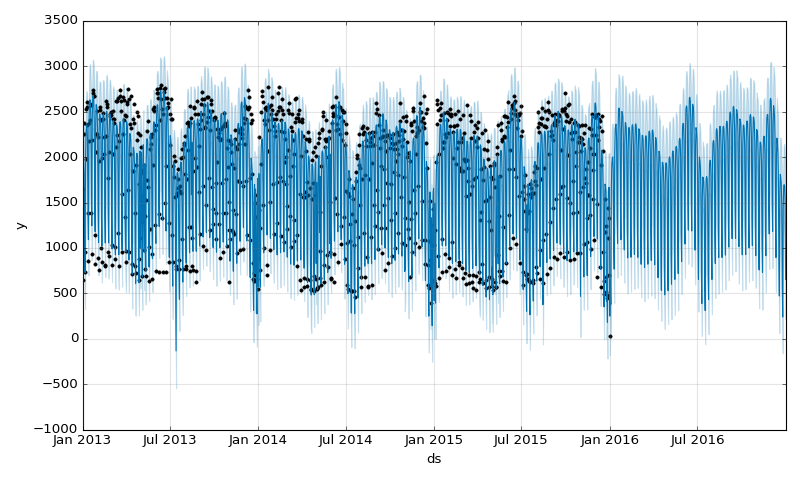

In [8]:
%matplotlib notebook
#%matplotlib inline
m.plot(forecast);

<IPython.core.display.Javascript object>


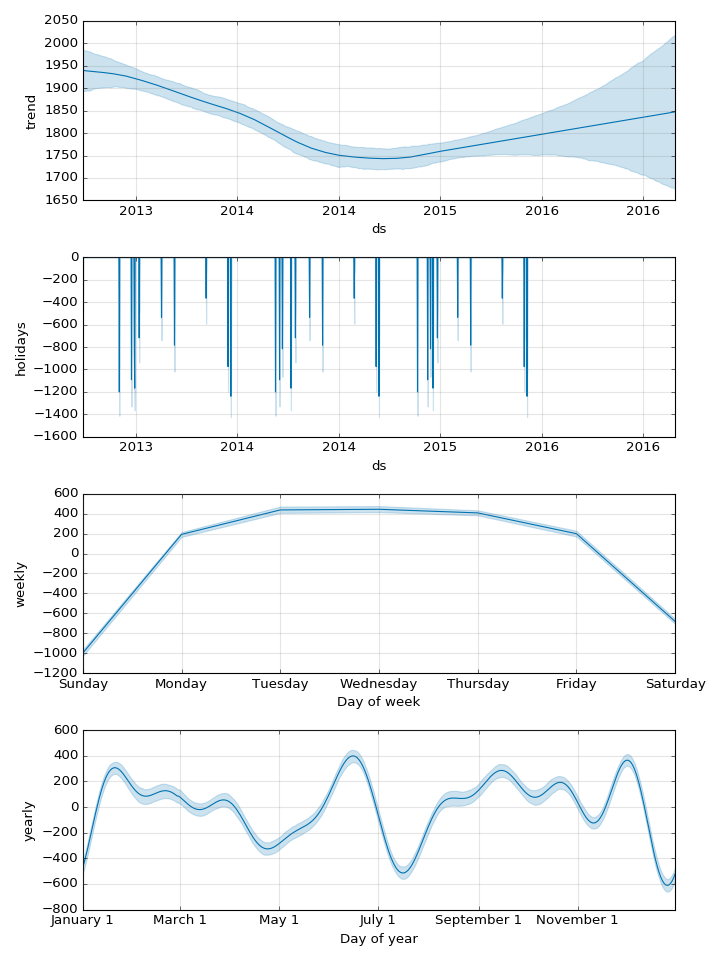

In [10]:
m.plot_components(forecast);

In [11]:
test = pd.concat([df.set_index('ds'), forecast.set_index('ds')], axis=1)
#test = test[~test['y'].isnull()]
print('RMSE', np.sqrt(((test['y'] - test['yhat'])**2).mean()))
print('MeanAE', ((test['y'] - test['yhat']).abs()).mean())
print('MedianAE', ((test['y'] - test['yhat']).abs()).median())
print('MAPE', ((test['y'] - test['yhat']).abs()/ test['y']).mean() * 100)

RMSE 281.506221871
MeanAE 213.115197197
MedianAE 171.36568258012505
MAPE 16.6287783927


In [12]:
test = pd.concat([df.set_index('ds'), forecast.set_index('ds')], axis=1)
#test = test[~test['y'].isnull()]
print('RMSE', np.sqrt(((test['y'] - test['yhat'])**2).mean()))
print('MeanAE', ((test['y'] - test['yhat']).abs()).mean())
print('MedianAE', ((test['y'] - test['yhat']).abs()).median())
print('MAPE', ((test['y'] - test['yhat']).abs()/ test['y']).mean() * 100)
print('CVRMSE',  np.sqrt(((test['y'] - test['yhat'])**2).mean())/np.nanmean(test['y']) * 100)

RMSE 281.506221871
MeanAE 213.115197197
MedianAE 171.36568258012505
MAPE 16.6287783927
CVRMSE 15.7042269158


In [13]:
out = forecast.set_index('ds').drop('t', axis=1)

In [72]:
out.to_csv('./data/prophet_forecast-tsdata.csv')